In [5]:
import sys
sys.path.append("../../functions")
from GS_data1d import intensity_profile, construct_DM1d, propagation_dm1d
from scipy.io import loadmat
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import eigh
from abtem.core.energy import energy2wavelength
from tqdm import tqdm

**Method** LOOCV

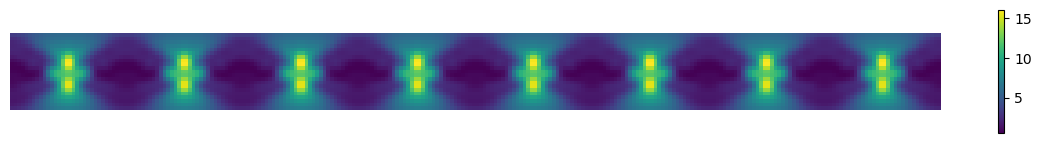

In [2]:
image_series = loadmat("../../data/Core_loss_3bc_STO/STO_3bc_simulation_large_defocus.mat")["images"]
n_row, n_col, n_df = image_series.shape
focal_series = np.sum(image_series, axis=1)
num_repeat = 8
focal_series = np.tile(focal_series.T, num_repeat).T[:,7:-7]
n_rowp = focal_series.shape[0]
defocus = np.arange(-28, 14, 2)*10
a = 3.905
rx = np.linspace(-a/2*num_repeat, a/2*num_repeat, n_rowp)
sampling = rx[1]-rx[0]; energy=300e3
fig, ax = plt.subplots(figsize=(15, 8))
im=ax.imshow(focal_series.T)
ax.axis("off")
fig.colorbar(im, shrink=0.2)
plt.show()

In [3]:
print(defocus)

[-280 -260 -240 -220 -200 -180 -160 -140 -120 -100  -80  -60  -40  -20
    0   20   40   60   80  100  120]


In [17]:
alpha_range = np.arange(0.1e-3, 1e-3, 0.2e-3)
error_rec = []
for alpha in alpha_range:
    Cs = 0
    delta = 1
    rmse_rec = []
    for index_cv in tqdm(range(0, defocus.shape[0], 5)):
        defocus_sel = np.concatenate((defocus[:index_cv], 
                                    defocus[index_cv+1:]))
        series_sel = np.hstack((focal_series[:,:index_cv], 
                                focal_series[:,index_cv+1:]))
        test_defocus = defocus[index_cv]
        test_focal_series = focal_series[:,index_cv]
        dm_rec, drift_list, stack_1dp = construct_DM1d(rx, series_sel, defocus_sel, 
                                                    sampling, energy, n_iter=100, 
                                                    apply_tcc=True, alpha=alpha, 
                                                    Cs=Cs, delta=delta, apply_tqdm=False)
        dm_prop = propagation_dm1d(dm_rec, test_defocus, energy, sampling, 
                                apply_tcc=True, alpha=alpha, Cs=Cs, delta=delta)
        intensity = intensity_profile(dm_prop)
        rmse = np.linalg.norm(intensity - test_focal_series)
        rmse_rec.append(rmse)
    rmse_rec = np.array(rmse_rec)
    rmse_mean = np.mean(rmse_rec)
    error_rec.append(rmse_mean)

100%|██████████| 5/5 [03:03<00:00, 36.62s/it]


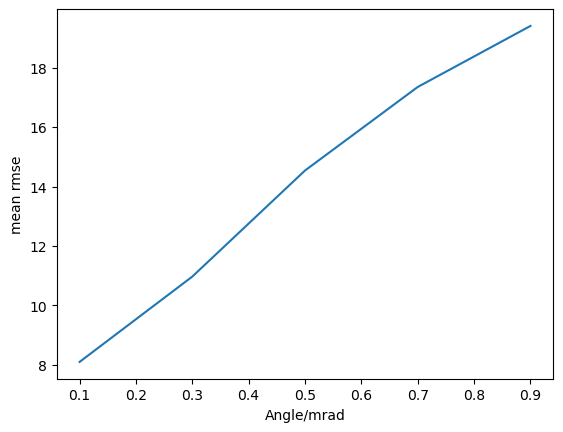

In [ ]:
error_rec = np.array(error_rec)
plt.plot(alpha_range*1e3, error_rec)
plt.xlabel("Angle/mrad")
plt.ylabel("mean rmse")
plt.show()

In [ ]:
plt.plot()